In [1]:
# Install libraries (may take ~1-2 minutes)
!pip install -q kaggle scikit-surprise xgboost imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Kaggle API: upload kaggle.json if you want to download datasets via Kaggle.
# If you don't have kaggle.json, skip this cell and upload CSVs manually later.

from google.colab import files
import os, sys

print("If you want to use Kaggle API, upload your kaggle.json now (from your Kaggle account -> API).")
uploaded = files.upload()  # choose kaggle.json

if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json','wb') as f:
        f.write(uploaded['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("Saved kaggle.json to ~/.kaggle/")
else:
    print("No kaggle.json uploaded. You can still upload CSV files manually in later cells.")

# Optional: mount Google Drive to save models / outputs
from google.colab import drive
print("\nMounting Google Drive (optional). Authorize when prompted.")
drive.mount('/content/drive')


If you want to use Kaggle API, upload your kaggle.json now (from your Kaggle account -> API).


Saving kaggle.json to kaggle.json
Saved kaggle.json to ~/.kaggle/

Mounting Google Drive (optional). Authorize when prompted.
Mounted at /content/drive


In [3]:
# Common imports and small helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os
from pathlib import Path

sns.set(style='whitegrid')
RANDOM_SEED = 42

def save_model(obj, fname='model.pkl', to_drive=False):
    path = Path('/content') / fname
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved: {path}")
    if to_drive and Path('/content/drive').exists():
        drive_path = Path('/content/drive/MyDrive') / fname
        with open(drive_path, 'wb') as f:
            pickle.dump(obj, f)
        print(f"Also saved to Drive: {drive_path}")

def download_if_exists(local_path):
    if Path(local_path).exists():
        print(f"Found {local_path}")
        return True
    return False

In [5]:
# Project 1 — Titanic (classification)
# Load the seaborn Titanic dataset, do quick EDA, train Logistic Regression + RandomForest.

Logistic Regression
Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Random Forest
Accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



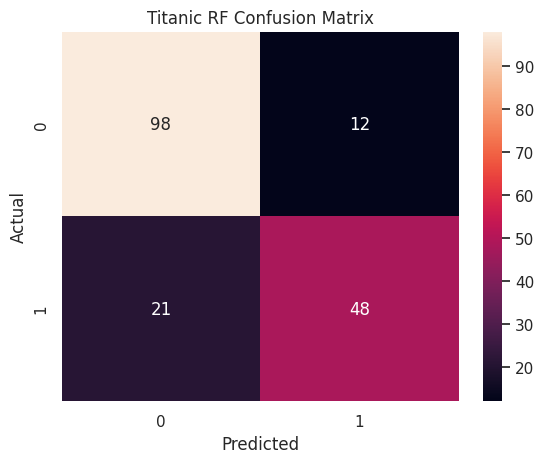

Saved: /content/titanic_rf.pkl
Also saved to Drive: /content/drive/MyDrive/titanic_rf.pkl


In [6]:
# Titanic: load and basic preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

titanic = sns.load_dataset('titanic')
df = titanic[['survived','pclass','sex','age','sibsp','parch','fare','embarked']].copy()

# simple preprocessing
df['sex'] = df['sex'].map({'male':0,'female':1})
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

X = df.drop('survived',axis=1)
y = df['survived']

# scale numeric
num_cols = ['age','fare','sibsp','parch']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_SEED, test_size=0.2)

# Baseline: Logistic Regression
lr = LogisticRegression(max_iter=400, random_state=RANDOM_SEED)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Stronger: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion matrix plot
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Titanic RF Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

# Save model (local + optional Drive)
save_model(rf, fname='titanic_rf.pkl', to_drive=True)
